## Data Cleaning

In [ ]:
import pandas as pd
import numpy as np

# Storing the dataset into the variable dataset and making the "DATE" column the index column.
dataset = pd.read_csv("weather.csv", index_col="DATE")

# For each column, store the percentage of missing values.
miss_pct = dataset.apply(pd.isnull).sum()/dataset.shape[0]

# List columns with low miss_pct (good columns); feel free to tweak the threshold of how low we want missing values to be.
good_columns = dataset.columns[miss_pct < 0.01]
dataset = dataset[good_columns].copy()
dataset.apply(pd.isnull).sum()/dataset.shape[0]

# Since the "PRCP" column has missin values, we fill the missing values with zero since
# if there was no PRCP recorded for that day then that must mean that it did not rain therefore PRCP would be zero
dataset["PRCP"] = dataset["PRCP"].fillna(0)

# confirming no NaNs left
dataset.apply(pd.isnull).sum() / dataset.shape[0]

# Change dtype from object to datetime.
dataset.index = pd.to_datetime(dataset.index)

In [1]:
# Change dtype from object to datetime.
dataset.index = pd.to_datetime(dataset.index)
# Checking for gaps in dataset (if certain years have more rows than others; ideally each year should have around 365-ish rows).
dataset.index.year.value_counts().sort_index().tail()

NameError: name 'pd' is not defined

<Axes: xlabel='DATE'>

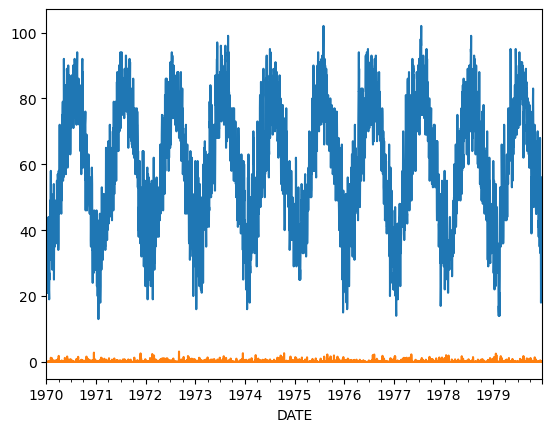

In [ ]:
# Plot of maximum temp and rain in Boston over 10 years
dataset["TMAX"].iloc[:3650].plot() # fix??
dataset["PRCP"].iloc[:3650].plot()

## Response Variable Creation

In [ ]:
# Filling in the new predictor tmrw_temp: 
# Shifting down the TMAX values by one position, which makes each value the next day's maximum temperature from the original TMAX column.
# Assigning this to a new column in the original DataFrame called tmrw_temp to align tomorrow's temperature prediction with the next day's max temperature.
dataset["tmrw_temp"] = dataset.shift(-1)["TMAX"]

# tmrw_rain predication (another response variable)
dataset["tmrw_rain"] = (dataset["PRCP"].shift(-1) > 0).astype(int)
dataset = dataset.dropna(subset=["tmrw_rain"])

dataset = dataset.iloc[:-1]
dataset

,STATION,NAME,PRCP,SNOW,TMAX,TMIN,tmrw_temp,tmrw_rain
DATE,,,,,,,,
1970-01-01,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",0.00,0.0,29,16,28.0,0
1970-01-02,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",0.00,0.0,28,19,30.0,1
1970-01-03,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",0.14,2.2,30,17,27.0,1
1970-01-04,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",0.02,0.2,27,19,30.0,0
1970-01-05,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",0.00,0.0,30,18,31.0,0
...,...,...,...,...,...,...,...,...
2025-03-11,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",0.00,0.0,62,34,50.0,0
2025-03-12,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",0.00,0.0,50,33,44.0,0
2025-03-13,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",0.00,0.0,44,34,46.0,0


## Feature Variable Correlation

Text(0.5, 1.0, 'Correlation Heatmap')

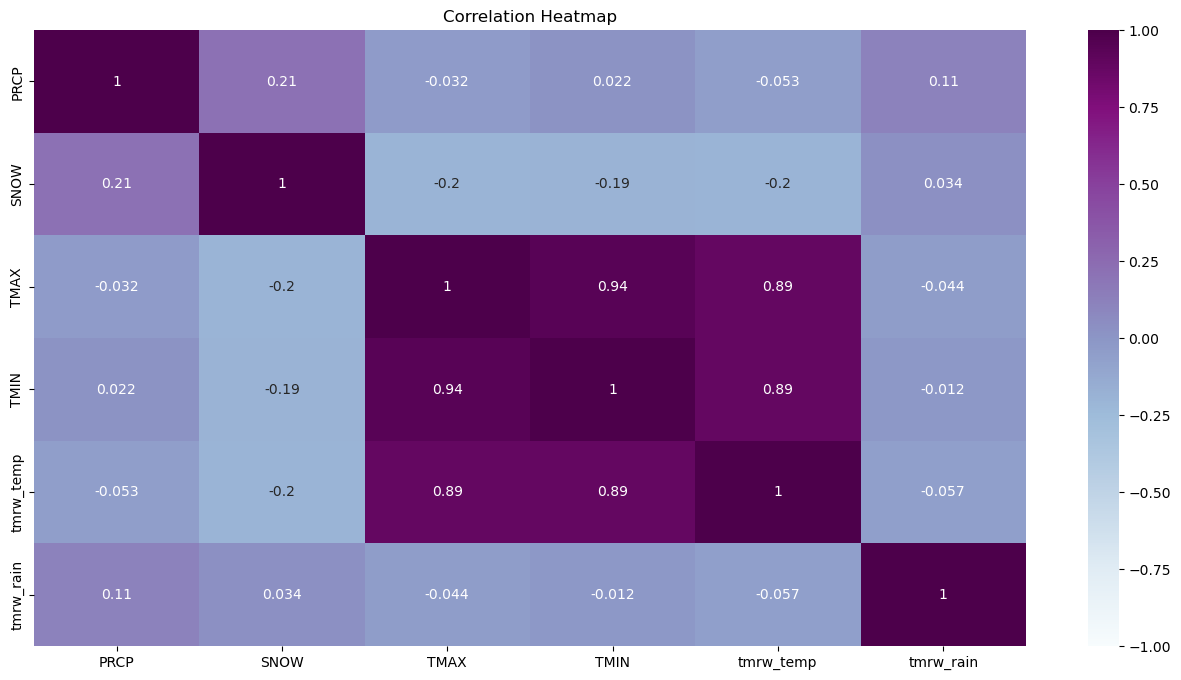

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Using Pearson correlation coefficient between the numeric predictors.
numeric_dataset = dataset.drop(columns=['STATION', 'NAME'], errors='ignore')

plt.figure(figsize=(16, 8))
heatmap = sns.heatmap(numeric_dataset.corr(), vmin=-1, vmax=1, annot=True, cmap='BuPu')
heatmap.set_title('Correlation Heatmap')

As we can see, TMAX and TMIN are heavily correlated, TMAX and tmrw_temp are also heavily correlated. 
Other predictors are not highly correlated, which makes sense.

## Baseline

Predictions based off of tomorrow's maximum temperature and chance of rain with today's maximum temperature and if it has rained

In [ ]:
temp_diff = np.diff(dataset['TMAX'].values)
prcp_diff = np.diff((dataset["PRCP"] > 0).astype(int))

print(temp_diff)
print(prcp_diff)

print("MAE if predicting tomorrow's max with today's max: ", np.mean(np.abs(temp_diff)))
print("% error if predicting tomorrow's rain with today's rain: ", np.mean(np.abs(prcp_diff)))

[-1  2 -3 ... -6  2 16]
[0 1 0 ... 0 0 0]
MAE if predicting tomorrow's max with today's max:  6.68143041364944
% error if predicting tomorrow's rain with today's rain:  0.38150977085606586


## Model Performance Evaluation

In [ ]:
from sklearn.base import clone

# In this example the model starts predicting after it 10 years, (training on 10 years and predicting the next years till 2025 in 30 day intervals to account for seasons and such)
def backtest(weather, model_temp, model_rain, predictors, start=3650, step=180):
    all_predictions_temp = []
    all_predictions_rain = []

    for i in range(start, weather.shape[0], step):
        # training is from day 1 to i, i here is 3650 so training would be done on first 10 years in this case!
        train = weather.iloc[:i,:]
        test = weather.iloc[i:(i+step),:]

        # fitting the model giving it the predictors and the target to train on
        model_temp.fit(train[predictors], train["tmrw_temp"])
        model_rain.fit(train[predictors], train["tmrw_rain"])

        # predicting the target for the test data but here we're obviously only given the predictors and our goal is to predict the target
        temp_preds = model_temp.predict(test[predictors])
        rain_preds = model_rain.predict(test[predictors])

        # creating series for manipulating and combining
        # temp_preds_series = pd.Series(temp_preds, index=test.index)
        # rain_preds_series = pd.Series(rain_preds, index=test.index)

        # combining each batch interval into one big list for both predictors
        temp_combined = pd.DataFrame({
            "actual_temp": test["tmrw_temp"],
            "predicted_temp": temp_preds,
            "temp_diff": (temp_preds - test["tmrw_temp"]).abs()
        }, index=test.index)

        rain_combined = pd.DataFrame({
            "actual_rain": test["tmrw_rain"],
            "predicted_rain": rain_preds,
            "rain_diff": (rain_preds - test["tmrw_rain"]).abs()
        }, index=test.index)
        
        # Combine both temperature and rain predictions
        all_predictions_temp.append(temp_combined)
        all_predictions_rain.append(rain_combined)
        
    return pd.concat(all_predictions_temp), pd.concat(all_predictions_rain)

### KNN Grid Search

In [ ]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

predictors = ['TMAX', 'TMIN', 'PRCP', 'SNOW']

X = dataset[predictors].dropna()
y = dataset['tmrw_temp'].dropna()

def perform_grid_search(dataset, predictors):
    # Prepare data
    clean_data = dataset.dropna(subset=predictors + ['tmrw_temp', 'tmrw_rain'])
    X = clean_data[predictors]

    knn_temp_model = KNeighborsRegressor()
    knn_rain_model = KNeighborsClassifier()

    param_grid = {'n_neighbors': range(1, 31)}

    # Define the TimeSeriesSplit for cross-validation
    tscv = TimeSeriesSplit(n_splits=10)

    # Grid Search for Temperature Prediction
    grid_search_temp = GridSearchCV(estimator=knn_temp_model, param_grid=param_grid, cv=tscv, scoring='neg_mean_absolute_error')
    grid_search_temp.fit(X, clean_data['tmrw_temp'])
    best_temp_model = grid_search_temp.best_estimator_
    best_k_temp = grid_search_temp.best_params_['n_neighbors']
    best_score_temp = -grid_search_temp.best_score_  # Convert score to positive

    # Grid Search for Rain Prediction
    grid_search_rain = GridSearchCV(estimator=knn_rain_model, param_grid=param_grid, cv=tscv, scoring='accuracy')
    grid_search_rain.fit(X, clean_data['tmrw_rain'])
    best_rain_model = grid_search_rain.best_estimator_
    best_k_rain = grid_search_rain.best_params_['n_neighbors']
    best_score_rain = grid_search_rain.best_score_

    results = {
        "Temperature Model": {
            "Best K": best_k_temp,
            "Best MAE": best_score_temp
        },
        "Rain Model": {
            "Best K": best_k_rain,
            "Best Accuracy": best_score_rain
        }
    }

    return results

# Perform Grid Search
grid_search_results = perform_grid_search(dataset, predictors)
best_k_temp = grid_search_results["Temperature Model"]["Best K"]
best_k_rain = grid_search_results["Rain Model"]["Best K"]

print("Temperature Prediction:")
print("Best K: ", best_k_temp)
print("Best Mean Absolute Error: {:.2f}".format(grid_search_results["Temperature Model"]["Best MAE"]))
print()
print("Rain Prediction:")
print("Best K: ", best_k_rain)
print("Best Accuracy: {:.2f}".format(grid_search_results["Rain Model"]["Best Accuracy"]))

Temperature Prediction:
Best K:  28
Best Mean Absolute Error: 6.33

Rain Prediction:
Best K:  30
Best Accuracy: 0.66


In [ ]:
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

# Setting up for tmrw_temp regression models
# Ridge Model
# alpha - imposing a penalty on the size of the coefficient, L2 norm, to prevent overfitting.
ridge_model = Ridge(alpha = 0.1)
knn_model_temp = KNeighborsRegressor(n_neighbors=best_k_temp) # KNN
rf_model_temp = RandomForestRegressor(n_estimators=100, random_state=42) # Random Forests
xgb_model_temp = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42) # XGBoost
gbr_model_temp = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42) # Gradient Boosting

# Setting up for tmrw_rain classification models
logistic_model = LogisticRegression()
knn_model_rain = KNeighborsClassifier(n_neighbors=best_k_rain)
rf_model_rain = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model_rain = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gbr_model_rain = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)


In [ ]:
temp_ridge, rain_logistic = backtest(dataset, ridge_model, logistic_model, predictors)
temp_knn, rain_knn = backtest(dataset, knn_model_temp, knn_model_rain, predictors)
temp_rf, rain_rf = backtest(dataset, rf_model_temp, rf_model_rain, predictors)
temp_xgb, rain_xgb = backtest(dataset, xgb_model_temp, xgb_model_rain, predictors)
temp_gbr, rain_gbr = backtest(dataset, gbr_model_temp, gbr_model_rain, predictors)

In [ ]:
# display(temp_ridge.head(), rain_logistic.head())
# display(temp_knn.head(), rain_knn.head())
# display(temp_rf.head(), rain_rf.head())
# display(temp_xgb.head(), rain_xgb.head())
# display(temp_gbr.head(), rain_gbr.head())

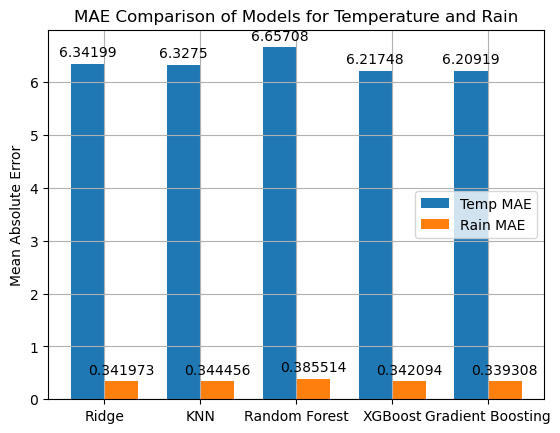

In [ ]:
import matplotlib.pyplot as plt

mae_results_temp = {
    "Ridge": temp_ridge["temp_diff"].mean(),
    "KNN": temp_knn["temp_diff"].mean(),
    "Random Forest": temp_rf["temp_diff"].mean(),
    "XGBoost": temp_xgb["temp_diff"].mean(),
    "Gradient Boosting": temp_gbr["temp_diff"].mean()
}

mae_results_rain = {
    "Ridge": rain_logistic["rain_diff"].mean(),
    "KNN": rain_knn["rain_diff"].mean(),
    "Random Forest": rain_rf["rain_diff"].mean(),
    "XGBoost": rain_xgb["rain_diff"].mean(),
    "Gradient Boosting": rain_gbr["rain_diff"].mean()
}

# labels for both tmrw_temp and tmrw_rain
labels = list(mae_results_temp.keys())
temp_mae = list(mae_results_temp.values())
rain_mae = list(mae_results_rain.values())

x = np.arange(len(labels))  # label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, temp_mae, width, label='Temp MAE')
rects2 = ax.bar(x + width/2, rain_mae, width, label='Rain MAE')

# labels, title, and axis tick labels
ax.set_ylabel('Mean Absolute Error')
ax.set_title('MAE Comparison of Models for Temperature and Rain')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

plt.grid(True)
plt.xticks(rotation=0)
plt.show()

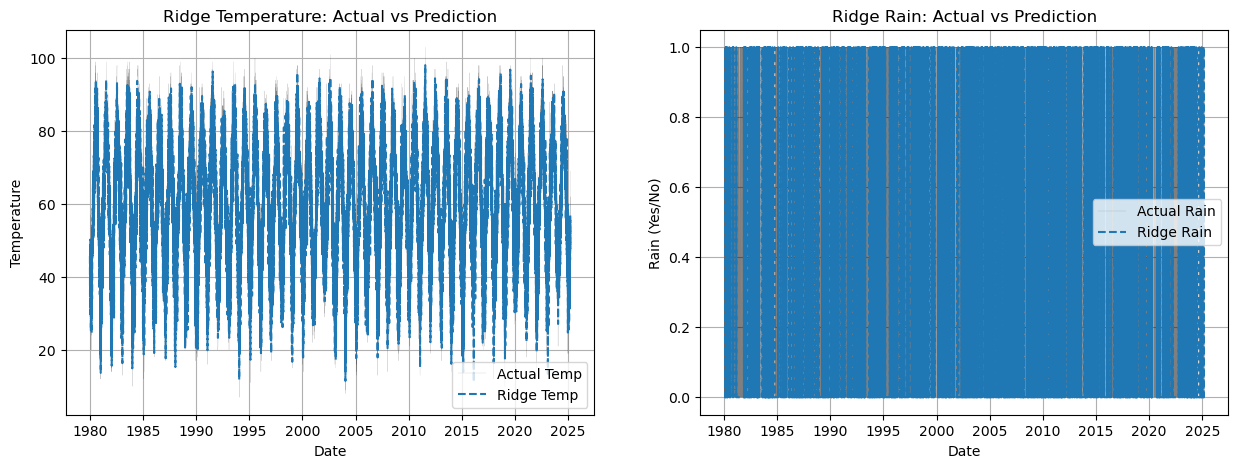

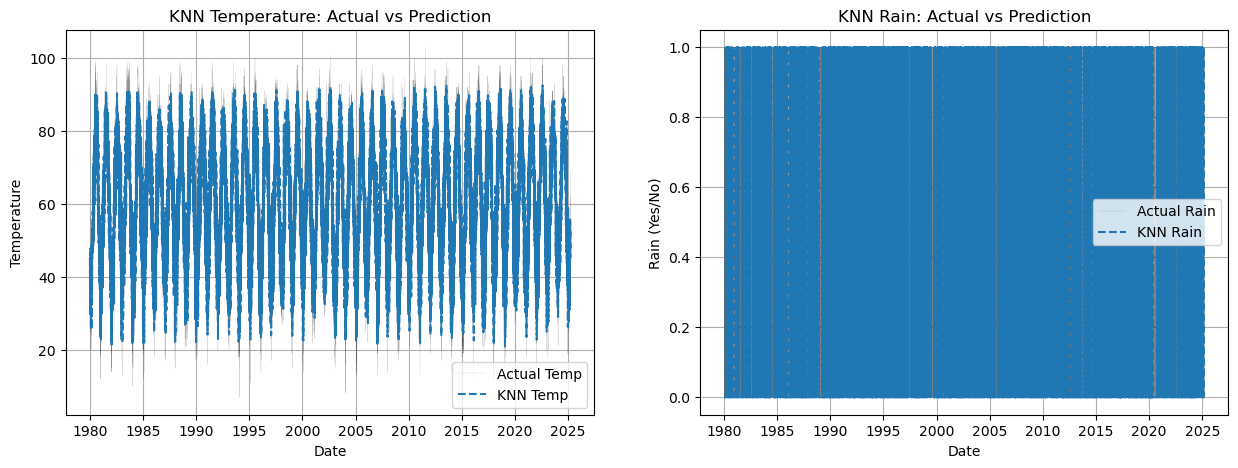

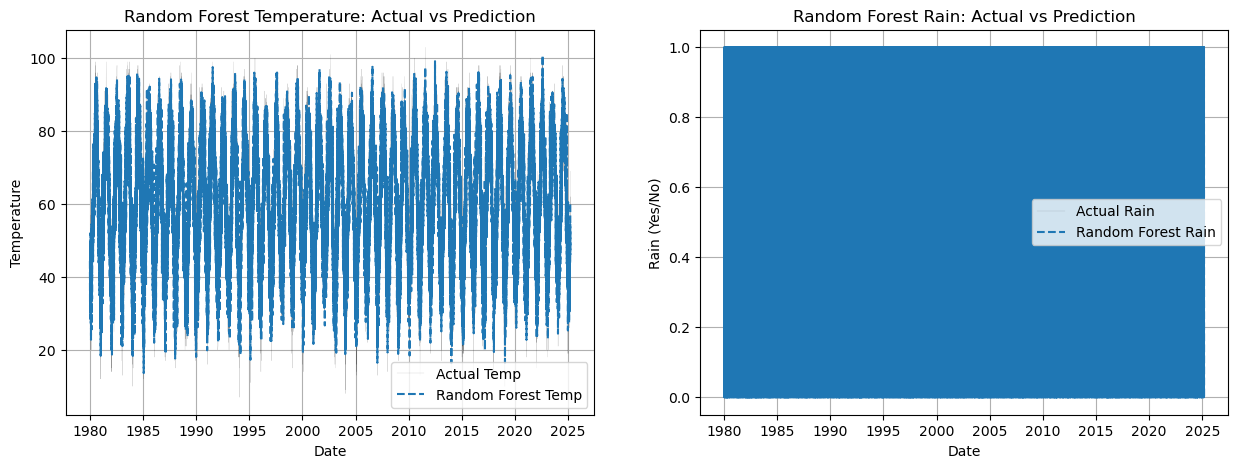

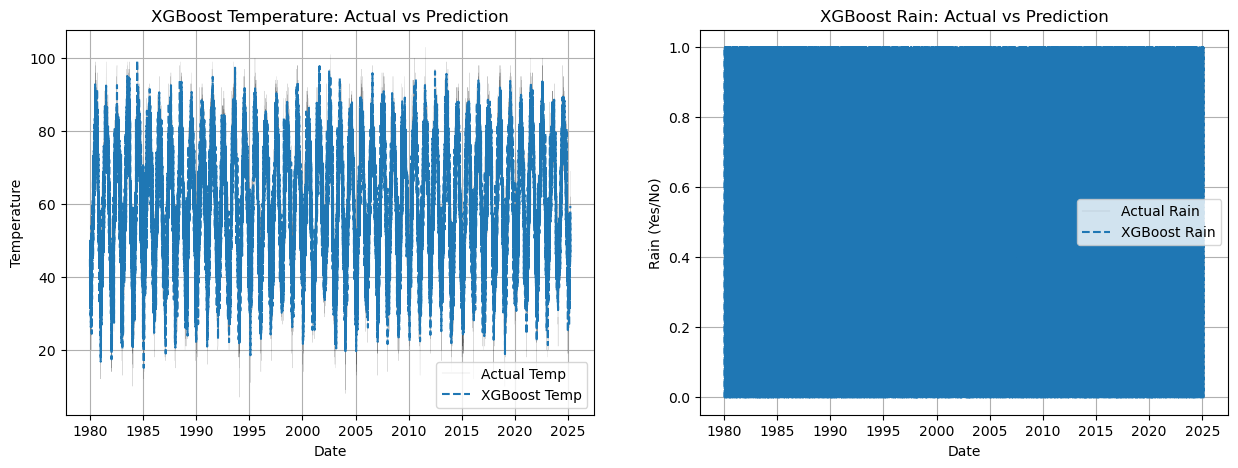

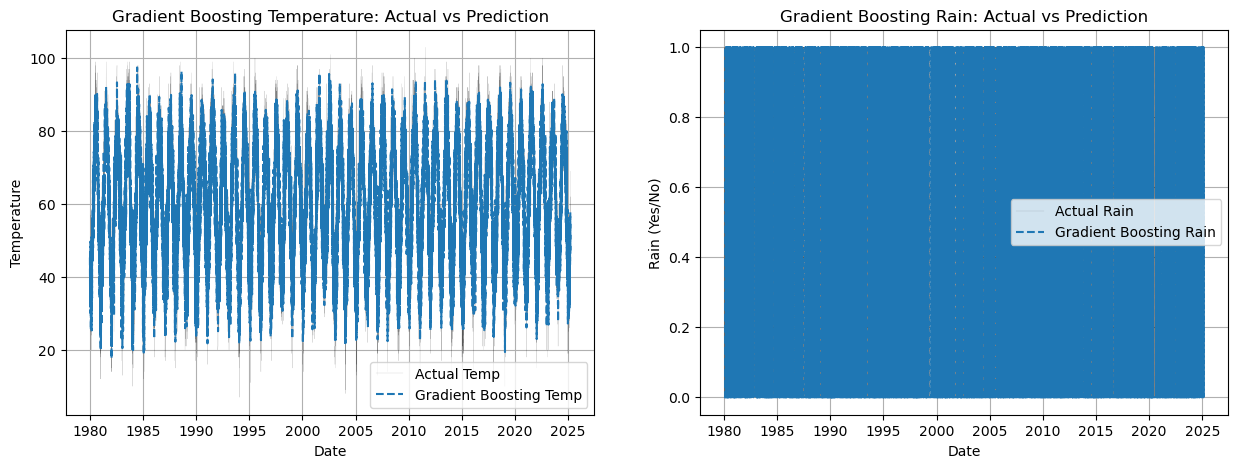

In [ ]:
import matplotlib.pyplot as plt

def plot_predictions(predictions_temp, predictions_rain, model_name):
    # Temperature Predictions
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    plt.plot(predictions_temp.index, predictions_temp["actual_temp"], label="Actual Temp", color="black", linewidth=0.1, alpha=0.5)
    plt.plot(predictions_temp.index, predictions_temp["predicted_temp"], label=f"{model_name} Temp", linestyle="--")
    plt.title(f"{model_name} Temperature: Actual vs Prediction")
    plt.xlabel("Date")
    plt.ylabel("Temperature")
    plt.legend()
    plt.grid(True)

    # Rain Predictions
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.plot(predictions_rain.index, predictions_rain["actual_rain"], label="Actual Rain", color="black", linewidth=0.1, alpha=0.5)
    plt.plot(predictions_rain.index, predictions_rain["predicted_rain"], label=f"{model_name} Rain", linestyle="--")
    plt.title(f"{model_name} Rain: Actual vs Prediction")
    plt.xlabel("Date")
    plt.ylabel("Rain (Yes/No)")
    plt.legend()
    plt.grid(True)

    plt.show()

# Plot for each method
plot_predictions(temp_ridge, rain_logistic, "Ridge")
plot_predictions(temp_knn, rain_knn, "KNN")
plot_predictions(temp_rf, rain_rf, "Random Forest")
plot_predictions(temp_xgb, rain_xgb, "XGBoost")
plot_predictions(temp_gbr, rain_gbr, "Gradient Boosting")

### Wen's visualizations

In [ ]:
# import matplotlib.pyplot as plt

# # 设置图像大小
# plt.figure(figsize=(15, 5))

# # Plot for Ridge Regression Model
# plt.plot(predictions_ridge10.index, predictions_ridge10["actual"], label="Actual", color="black", alpha=0.5)
# plt.plot(predictions_ridge10.index, predictions_ridge10["prediction"], label="Ridge", linestyle="--")

# plt.title("Ridge Regression Actual vs Prediction")
# plt.xlabel("Date")
# plt.ylabel("Temperature")
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plot for KNN
# plt.plot(predictions_knn10.index, predictions_knn10["actual"], label="Actual", color="black", alpha=0.5)
# plt.plot(predictions_knn10.index, predictions_knn10["prediction"], label="KNN", linestyle="--")

# plt.title("KNN Actual vs Prediction")
# plt.xlabel("Date")
# plt.ylabel("Temperature")
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plot for Random Forest
# plt.plot(predictions_rf10.index, predictions_rf10["actual"], label="Actual", color="black", alpha=0.5)
# plt.plot(predictions_rf10.index, predictions_rf10["prediction"], label="Random Forest", linestyle="--")

# plt.title("Random Forest: Actual vs Prediction")
# plt.xlabel("Date")
# plt.ylabel("Temperature")
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plot for XGBoost
# plt.figure(figsize=(15, 5))
# plt.plot(predictions_xgb10.index, predictions_xgb10["actual"], label="Actual", color="black", alpha=0.5)
# plt.plot(predictions_xgb10.index, predictions_xgb10["prediction"], label="XGBoost", linestyle="--")

# plt.title("XGBoost: Actual vs Prediction")
# plt.xlabel("Date")
# plt.ylabel("Temperature")
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plot for Gradient Boosting
# plt.figure(figsize=(15, 5))
# plt.plot(predictions_gbr10.index, predictions_gbr10["actual"], label="Actual", color="black", alpha=0.5)
# plt.plot(predictions_gbr10.index, predictions_gbr10["prediction"], label="Gradient Boosting", linestyle="--")

# plt.title("Gradient Boosting: Actual vs Prediction")
# plt.xlabel("Date")
# plt.ylabel("Temperature")
# plt.legend()
# plt.grid(True)
# plt.show()

## Visualizations of All Models

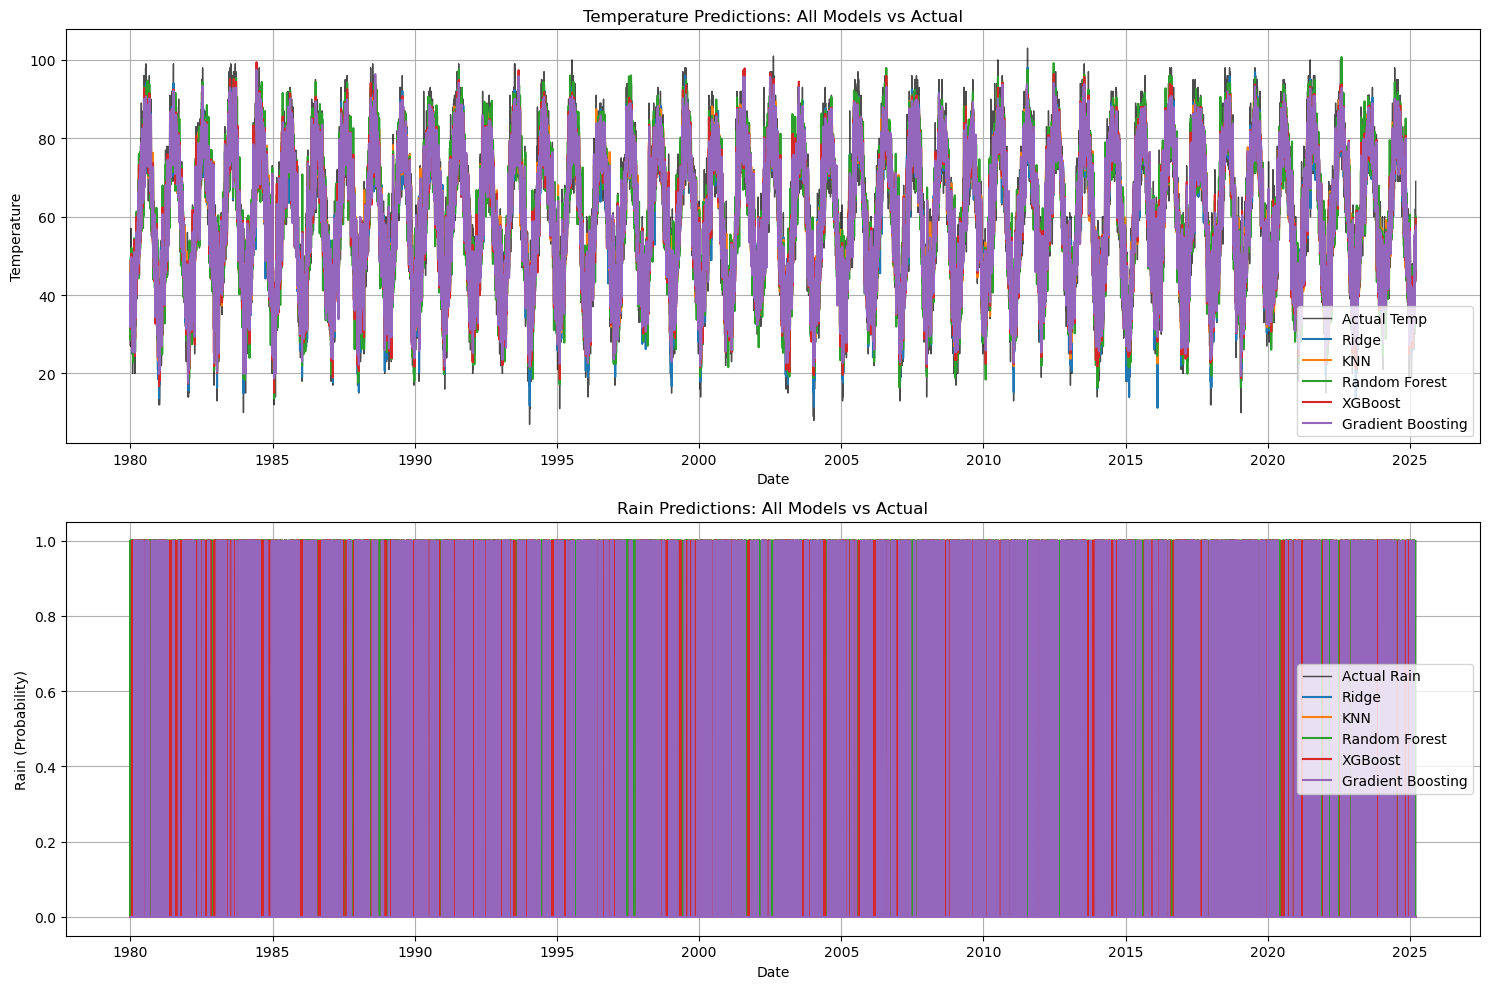

In [ ]:
import matplotlib.pyplot as plt

# Set up the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))  # 2 rows, 1 column

# Plotting Temperature Predictions
ax1.plot(temp_ridge.index, temp_ridge["actual_temp"], label="Actual Temp", color="black", linewidth=1, alpha=0.7)
ax1.plot(temp_ridge.index, temp_ridge["predicted_temp"], label="Ridge")
ax1.plot(temp_knn.index, temp_knn["predicted_temp"], label="KNN")
ax1.plot(temp_rf.index, temp_rf["predicted_temp"], label="Random Forest")
ax1.plot(temp_xgb.index, temp_xgb["predicted_temp"], label="XGBoost")
ax1.plot(temp_gbr.index, temp_gbr["predicted_temp"], label="Gradient Boosting")

ax1.set_title("Temperature Predictions: All Models vs Actual")
ax1.set_xlabel("Date")
ax1.set_ylabel("Temperature")
ax1.legend()
ax1.grid(True)

# Plotting Rain Predictions
ax2.plot(rain_logistic.index, rain_logistic["actual_rain"], label="Actual Rain", color="black", linewidth=1, alpha=0.7)
ax2.plot(rain_logistic.index, rain_logistic["predicted_rain"], label="Ridge")
ax2.plot(rain_knn.index, rain_knn["predicted_rain"], label="KNN")
ax2.plot(rain_rf.index, rain_rf["predicted_rain"], label="Random Forest")
ax2.plot(rain_xgb.index, rain_xgb["predicted_rain"], label="XGBoost")
ax2.plot(rain_gbr.index, rain_gbr["predicted_rain"], label="Gradient Boosting")

ax2.set_title("Rain Predictions: All Models vs Actual")
ax2.set_xlabel("Date")
ax2.set_ylabel("Rain (Probability)")
ax2.legend()
ax2.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Attempting to improve accuracy (reduce average difference in temperature) by increasing the amount of data we train on from 10 years to 30 years:

temp_ridge30, rain_logistic30 = backtest(dataset, ridge_model, logistic_model, predictors, start=(365*30))
temp_knn30, rain_knn30 = backtest(dataset, knn_model_temp, knn_model_rain, predictors, start=(365*30))
temp_rf30, rain_rf30 = backtest(dataset, rf_model_temp, rf_model_rain, predictors, start=(365*30))
temp_xgb30, rain_xgb30 = backtest(dataset, xgb_model_temp, xgb_model_rain, predictors, start=(365*30))
temp_gbr30, rain_gbr30 = backtest(dataset, gbr_model_temp, gbr_model_rain, predictors, start=(365*30))

In [ ]:
# Measuring how accurate our model is for 30 year predictions using mean absolute error:
import pandas as pd

# tmrw_temp
temp_ridge_mae30 = temp_ridge30["temp_diff"].mean()
temp_knn_mae30 = temp_knn30["temp_diff"].mean()
temp_rf_mae30 = temp_rf30["temp_diff"].mean()
temp_xgb_mae30 = temp_xgb30["temp_diff"].mean()
temp_gbr_mae30 = temp_gbr30["temp_diff"].mean()

# tmrw_rain
rain_logistic_mae30 = rain_logistic30["rain_diff"].mean()
rain_knn_mae30 = rain_knn30["rain_diff"].mean()
rain_rf_mae30 = rain_rf30["rain_diff"].mean()
rain_xgb_mae30 = rain_xgb30["rain_diff"].mean()
rain_gbr_mae30 = rain_gbr30["rain_diff"].mean()

mae_results = {
    'Model': ['Ridge', 'KNN', 'Random Forest', 'XGBoost', 'Gradient Boosting'],
    'Temp MAE 30 Year': [
        round(temp_ridge_mae30, 4),
        round(temp_knn_mae30, 4),
        round(temp_rf_mae30, 4),
        round(temp_xgb_mae30, 4),
        round(temp_gbr_mae30, 4) 
    ],
    'Rain MAE 30 Year': [
        round(rain_logistic_mae30, 4),
        round(rain_knn_mae30, 4),
        round(rain_rf_mae30, 4),
        round(rain_xgb_mae30, 4),
        round(rain_gbr_mae30, 4)
    ]
}

df_mae = pd.DataFrame(mae_results)
print(df_mae.to_string(index=False))

            Model  Temp MAE 30 Year  Rain MAE 30 Year
            Ridge            6.2855            0.3485
              KNN            6.2567            0.3446
    Random Forest            6.4819            0.3832
          XGBoost            6.1199            0.3451
Gradient Boosting            6.1416            0.3422


TypeError: unsupported operand type(s) for +: 'int' and 'method'

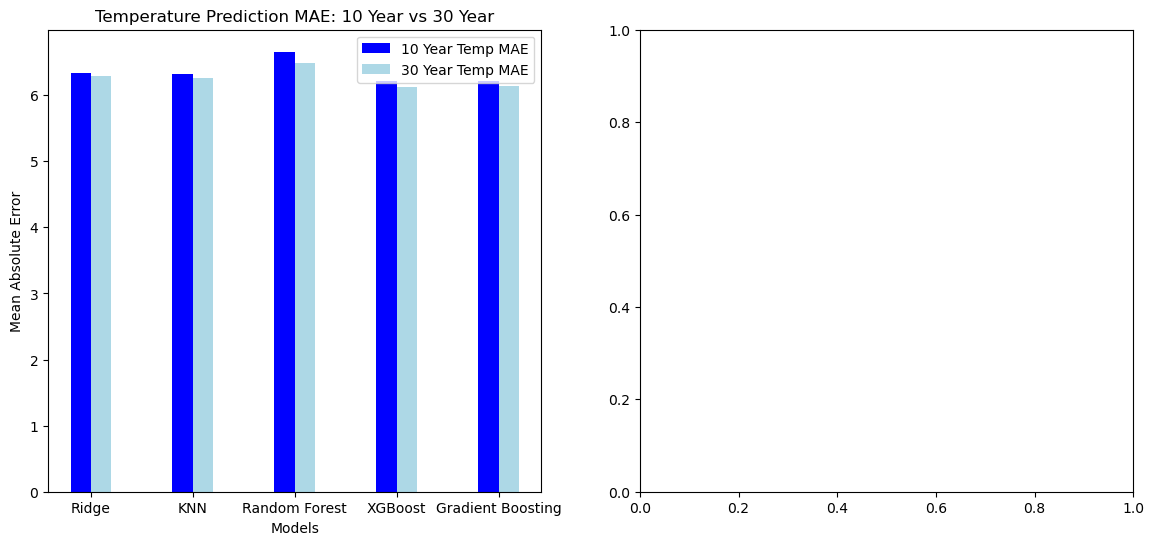

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# All MAE results for both temp and rain (10 and 30 year predictions)
mae_10_year_temp = [temp_ridge["temp_diff"].mean(), temp_knn["temp_diff"].mean(), temp_rf["temp_diff"].mean(), temp_xgb["temp_diff"].mean(), temp_gbr["temp_diff"].mean()]
mae_30_year_temp = [temp_ridge_mae30, temp_knn_mae30, temp_rf_mae30, temp_xgb_mae30, temp_gbr_mae30]

mae_10_year_rain = [rain_logistic["rain_diff"].mean, rain_knn["rain_diff"].mean(), rain_rf["rain_diff"].mean(), rain_xgb["rain_diff"].mean(), rain_gbr["rain_diff"].mean()]
mae_30_year_rain = [rain_logistic_mae30, rain_knn_mae30, rain_rf_mae30, rain_xgb_mae30, rain_gbr_mae30]

models = ['Ridge', 'KNN', 'Random Forest', 'XGBoost', 'Gradient Boosting']

x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot for Temperature MAEs
ax1.bar(x - width/2, mae_10_year_temp, width, label='10 Year Temp MAE', color='blue')
ax1.bar(x + width/2, mae_30_year_temp, width, label='30 Year Temp MAE', color='lightblue')
ax1.set_xlabel('Models')
ax1.set_ylabel('Mean Absolute Error')
ax1.set_title('Temperature Prediction MAE: 10 Year vs 30 Year')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()

# Plot for Rain MAEs
ax2.bar(x - width/2, mae_10_year_rain, width, label='10 Year Rain MAE', color='red')
ax2.bar(x + width/2, mae_30_year_rain, width, label='30 Year Rain MAE', color='pink')
ax2.set_xlabel('Models')
ax2.set_ylabel('Mean Absolute Error')
ax2.set_title('Rain Prediction MAE: 10 Year vs 30 Year')
ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.legend()

fig.tight_layout()
plt.show()
